# LSTM Stock Predictor Using Fear and Greed Index

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin fear and greed index values to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [26]:
import numpy as np
import pandas as pd
import hvplot.pandas

In [27]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [28]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv(
    './data/btc_sentiment.csv', 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True,
)

df = df.drop(columns='fng_classification')
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [29]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv(
    './data/btc_historic.csv', 
    index_col='Date', 
    infer_datetime_format=True, 
    parse_dates=True,
)['Close'].to_frame()

df2 = df2.sort_index()
df2.tail()

,Close
Date,
2019-07-25,9882.429688
2019-07-26,9847.450195
2019-07-27,9478.320313
2019-07-28,9531.769531
2019-07-29,9529.889648


In [30]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [31]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [32]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X and y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [33]:
# Predict Closing Prices using a 10 day window of previous fng values
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [38]:
# Use 70% of the data for training and the remainder for testing
# To avoid the dataset being randomized, we will manually split the data using array slicing.
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [39]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the training feature data X_train
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the training target data y_train
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [41]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [68]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features
num_units = 5
dropout_fraction = 0.2

model = Sequential([
    
    LSTM(
        units=num_units,
        return_sequences=True,
        input_shape=(X_train.shape[1], 1),
    ),
    Dropout(dropout_fraction),

    # Layer 2
    # LSTM(units=num_units, return_sequences=True),
    # Dropout(dropout_fraction),

    # Layer 3
    LSTM(units=num_units),
    Dropout(dropout_fraction),

    # Output layer
    Dense(1),
])

In [69]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")


In [70]:
# Summarize the model
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 10, 5)             140       
                                                                 
 dropout_5 (Dropout)         (None, 10, 5)             0         
                                                                 
 lstm_6 (LSTM)               (None, 5)                 220       
                                                                 
 dropout_6 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 366
Trainable params: 366
Non-trainable params: 0
_________________________________________________________________


In [71]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)


Epoch 1/10
372/372 [==============================] - 6s 7ms/step - loss: 0.0638
Epoch 2/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0488
Epoch 3/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0454
Epoch 4/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0439
Epoch 5/10
372/372 [==============================] - 4s 10ms/step - loss: 0.0437
Epoch 6/10
372/372 [==============================] - 2s 6ms/step - loss: 0.0437
Epoch 7/10
372/372 [==============================] - 3s 8ms/step - loss: 0.0456
Epoch 8/10
372/372 [==============================] - 2s 6ms/step - loss: 0.0480
Epoch 9/10
372/372 [==============================] - 2s 6ms/step - loss: 0.0463
Epoch 10/10
372/372 [==============================] - 2s 6ms/step - loss: 0.0496


In [73]:
model.fit(X_train, y_train, epochs=20, shuffle=False, batch_size=1, verbose=1)

Epoch 1/20
372/372 [==============================] - 2s 6ms/step - loss: 0.0298
Epoch 2/20
372/372 [==============================] - 2s 7ms/step - loss: 0.0447
Epoch 3/20
372/372 [==============================] - 2s 7ms/step - loss: 0.0453
Epoch 4/20
372/372 [==============================] - 2s 6ms/step - loss: 0.0460
Epoch 5/20
372/372 [==============================] - 2s 6ms/step - loss: 0.0466
Epoch 6/20
372/372 [==============================] - 2s 6ms/step - loss: 0.0474
Epoch 7/20
372/372 [==============================] - 2s 6ms/step - loss: 0.0479
Epoch 8/20
372/372 [==============================] - 2s 6ms/step - loss: 0.0464
Epoch 9/20
372/372 [==============================] - 2s 6ms/step - loss: 0.0480
Epoch 10/20
372/372 [==============================] - 2s 6ms/step - loss: 0.0475
Epoch 11/20
372/372 [==============================] - 2s 7ms/step - loss: 0.0459
Epoch 12/20
372/372 [==============================] - 2s 7ms/step - loss: 0.0489
Epoch 13/20
372/372 [====

---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [74]:
# Evaluate the model
model.evaluate(X_test, y_test)


5/5 [==============================] - 1s 6ms/step - loss: 0.1288


0.12876471877098083

In [75]:
# Make some predictions
predicted = model.predict(X_test)

5/5 [==============================] - 1s 4ms/step


In [83]:
# Recover the original prices instead of the scaled version
from sklearn.preprocessing import StandardScaler

y_test_scaler = StandardScaler()
y_test_scaler.fit(y_test)

predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

In [84]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.tail()

,Real,Predicted
2019-07-25,0.720479,0.542090
2019-07-26,0.724871,0.537098
2019-07-27,0.723478,0.539042
2019-07-28,0.708779,0.535330
2019-07-29,0.710907,0.538705


<AxesSubplot:>

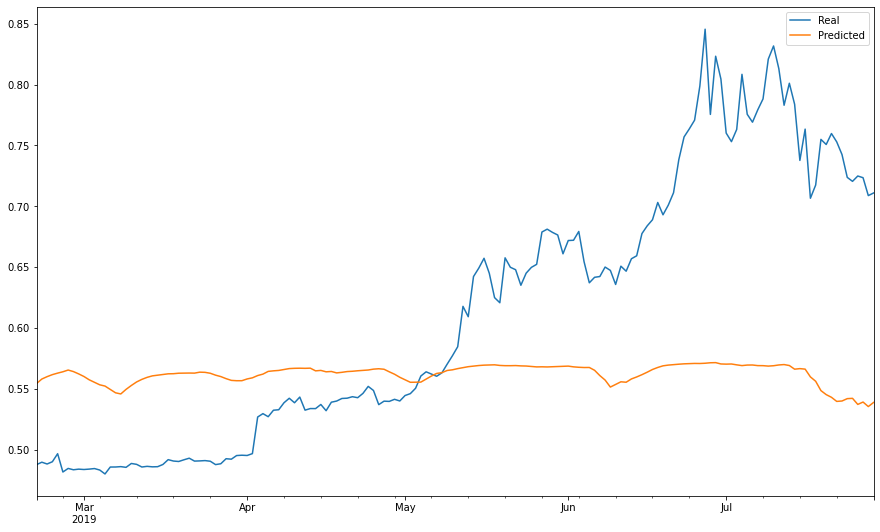

In [85]:
# Plot the real vs predicted values as a line chart
stocks.plot(figsize=(15,9))